# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

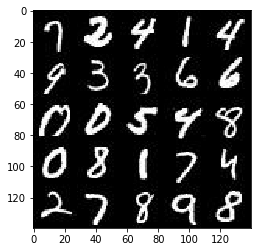

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

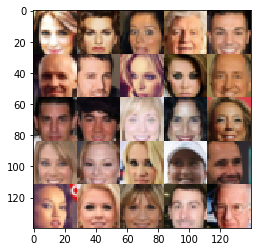

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    i_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr      = tf.placeholder(tf.float32, name="learning_rate")
    return i_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # similar to previous execise
    alpha = 0.3
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3     
        x2 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # similar to previous execise, but different image size, one layer less
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_dim = out_channel_dim
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    
    steps = 0
    print_every = 10
    show_every  = 50
    # extract image format
    image_height = data_shape[1]
    image_width = data_shape[2]
    image_channels = 1
    if data_image_mode == "RGB":
        image_channels = 3
    losses = []
    # rest straight forward from last execise:
    input_i, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_i, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # scaling up to [-1,1] range
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_i: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_i: batch_images, lr: learning_rate*0.8})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_i: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "d_loss: {:.4f}...".format(train_loss_d),
                          "g_loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                    

    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... d_loss: 1.2292... g_loss: 0.4731
Epoch 1/2... d_loss: 0.1874... g_loss: 2.1748
Epoch 1/2... d_loss: 0.2000... g_loss: 2.1990
Epoch 1/2... d_loss: 0.9740... g_loss: 0.6334
Epoch 1/2... d_loss: 2.3759... g_loss: 0.1465


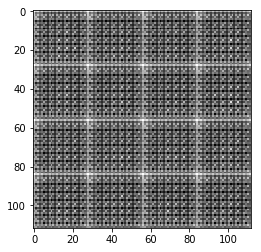

Epoch 1/2... d_loss: 0.9510... g_loss: 2.9215
Epoch 1/2... d_loss: 0.4685... g_loss: 1.5487
Epoch 1/2... d_loss: 0.4318... g_loss: 1.9190
Epoch 1/2... d_loss: 1.9856... g_loss: 0.2245
Epoch 1/2... d_loss: 0.9201... g_loss: 1.0518


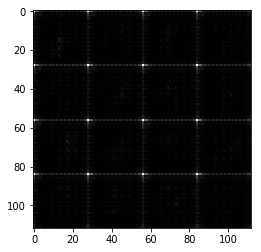

Epoch 1/2... d_loss: 1.2892... g_loss: 0.5488
Epoch 1/2... d_loss: 0.9854... g_loss: 1.6512
Epoch 1/2... d_loss: 0.8324... g_loss: 1.2435
Epoch 1/2... d_loss: 0.8861... g_loss: 1.4691
Epoch 1/2... d_loss: 0.8648... g_loss: 1.0202


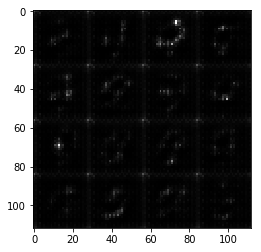

Epoch 1/2... d_loss: 0.9964... g_loss: 0.8947
Epoch 1/2... d_loss: 1.3938... g_loss: 0.4006
Epoch 1/2... d_loss: 1.1084... g_loss: 0.7365
Epoch 1/2... d_loss: 0.9760... g_loss: 1.3618
Epoch 1/2... d_loss: 1.1119... g_loss: 0.5520


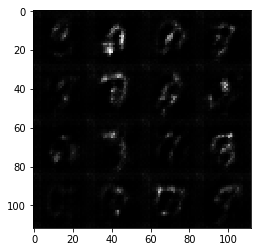

Epoch 1/2... d_loss: 1.2745... g_loss: 1.5658
Epoch 1/2... d_loss: 1.0237... g_loss: 1.1548
Epoch 1/2... d_loss: 1.0526... g_loss: 0.8198
Epoch 1/2... d_loss: 1.1090... g_loss: 0.5931
Epoch 1/2... d_loss: 1.0549... g_loss: 1.0528


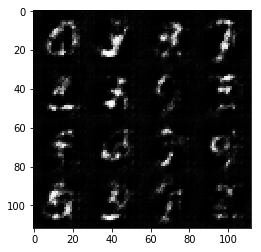

Epoch 1/2... d_loss: 1.0127... g_loss: 0.9619
Epoch 1/2... d_loss: 1.0243... g_loss: 0.7212
Epoch 1/2... d_loss: 1.2643... g_loss: 1.7089
Epoch 1/2... d_loss: 1.0028... g_loss: 0.7433
Epoch 1/2... d_loss: 0.9793... g_loss: 0.8085


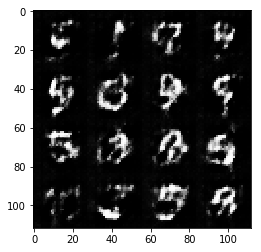

Epoch 1/2... d_loss: 1.1399... g_loss: 1.3995
Epoch 1/2... d_loss: 1.2013... g_loss: 0.5912
Epoch 1/2... d_loss: 1.0250... g_loss: 1.0603
Epoch 1/2... d_loss: 1.0727... g_loss: 1.0808
Epoch 1/2... d_loss: 1.1592... g_loss: 0.5826


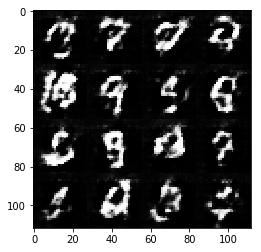

Epoch 1/2... d_loss: 0.9486... g_loss: 1.3706
Epoch 1/2... d_loss: 0.8335... g_loss: 1.3527
Epoch 1/2... d_loss: 1.1339... g_loss: 0.5534
Epoch 1/2... d_loss: 0.9508... g_loss: 0.7723
Epoch 1/2... d_loss: 1.0494... g_loss: 0.7490


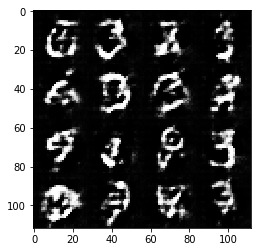

Epoch 1/2... d_loss: 0.9321... g_loss: 0.8611
Epoch 1/2... d_loss: 0.8132... g_loss: 1.0651
Epoch 1/2... d_loss: 0.8421... g_loss: 1.3951
Epoch 1/2... d_loss: 1.6360... g_loss: 0.2538
Epoch 1/2... d_loss: 0.8677... g_loss: 1.1815


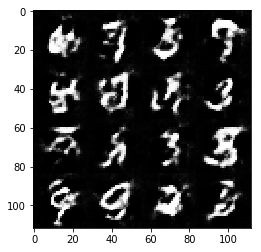

Epoch 1/2... d_loss: 0.9497... g_loss: 0.6534
Epoch 1/2... d_loss: 0.9152... g_loss: 0.9131
Epoch 1/2... d_loss: 0.9823... g_loss: 0.7230
Epoch 1/2... d_loss: 0.8064... g_loss: 1.0631
Epoch 1/2... d_loss: 1.0558... g_loss: 1.8472


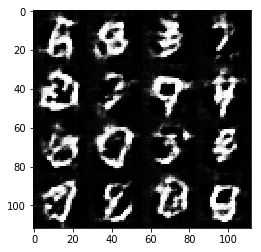

Epoch 1/2... d_loss: 1.0649... g_loss: 0.6314
Epoch 1/2... d_loss: 0.9400... g_loss: 0.7449
Epoch 1/2... d_loss: 0.9241... g_loss: 0.7577
Epoch 1/2... d_loss: 1.1285... g_loss: 0.5402
Epoch 1/2... d_loss: 0.9548... g_loss: 1.4576


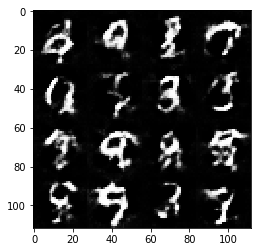

Epoch 1/2... d_loss: 0.9728... g_loss: 0.8638
Epoch 1/2... d_loss: 0.8887... g_loss: 1.2219
Epoch 1/2... d_loss: 0.9569... g_loss: 2.0421
Epoch 1/2... d_loss: 1.0328... g_loss: 1.9133
Epoch 1/2... d_loss: 1.0353... g_loss: 0.8890


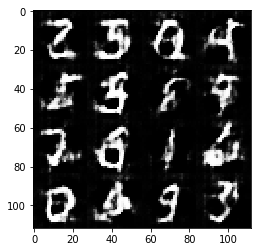

Epoch 1/2... d_loss: 1.3414... g_loss: 1.5330
Epoch 1/2... d_loss: 0.8345... g_loss: 1.1879
Epoch 1/2... d_loss: 0.8499... g_loss: 1.2914
Epoch 1/2... d_loss: 0.9775... g_loss: 0.7766
Epoch 1/2... d_loss: 1.0442... g_loss: 1.6919


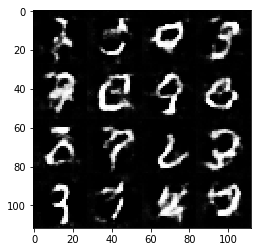

Epoch 1/2... d_loss: 0.9292... g_loss: 1.3313
Epoch 1/2... d_loss: 1.1950... g_loss: 1.5904
Epoch 1/2... d_loss: 0.9723... g_loss: 1.1964
Epoch 1/2... d_loss: 1.4805... g_loss: 0.3312
Epoch 1/2... d_loss: 0.9933... g_loss: 0.9512


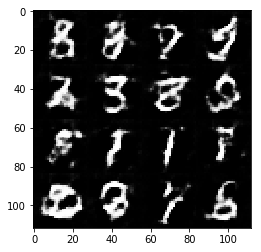

Epoch 1/2... d_loss: 1.0924... g_loss: 0.6549
Epoch 1/2... d_loss: 1.0677... g_loss: 0.7501
Epoch 1/2... d_loss: 1.2236... g_loss: 0.5861
Epoch 1/2... d_loss: 1.0268... g_loss: 0.9106
Epoch 1/2... d_loss: 1.0430... g_loss: 0.8434


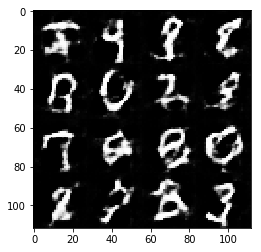

Epoch 1/2... d_loss: 1.0126... g_loss: 1.3019
Epoch 1/2... d_loss: 1.0732... g_loss: 1.2165
Epoch 1/2... d_loss: 1.4204... g_loss: 0.3474
Epoch 1/2... d_loss: 1.1931... g_loss: 0.5862
Epoch 1/2... d_loss: 1.1209... g_loss: 1.0175


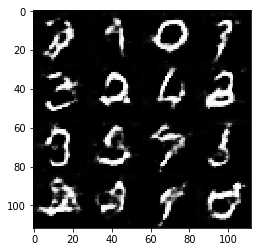

Epoch 1/2... d_loss: 1.0767... g_loss: 0.7118
Epoch 1/2... d_loss: 1.1363... g_loss: 1.6345
Epoch 1/2... d_loss: 1.2695... g_loss: 0.4785
Epoch 1/2... d_loss: 1.0988... g_loss: 1.4651
Epoch 1/2... d_loss: 1.0427... g_loss: 0.7530


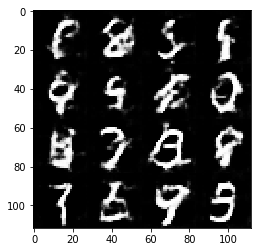

Epoch 1/2... d_loss: 1.1332... g_loss: 1.2836
Epoch 1/2... d_loss: 1.2040... g_loss: 0.4730
Epoch 1/2... d_loss: 1.2093... g_loss: 1.8690
Epoch 1/2... d_loss: 0.9198... g_loss: 0.8701
Epoch 1/2... d_loss: 1.1445... g_loss: 0.5562


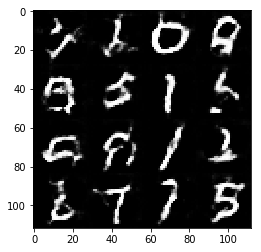

Epoch 1/2... d_loss: 0.9691... g_loss: 1.2735
Epoch 1/2... d_loss: 0.9868... g_loss: 0.8244
Epoch 1/2... d_loss: 1.3487... g_loss: 0.3911
Epoch 2/2... d_loss: 1.3956... g_loss: 1.8305
Epoch 2/2... d_loss: 1.1935... g_loss: 0.4626


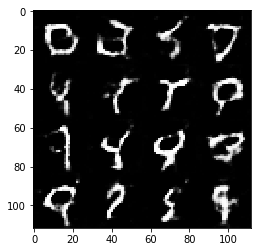

Epoch 2/2... d_loss: 1.0496... g_loss: 1.2248
Epoch 2/2... d_loss: 1.0511... g_loss: 0.5729
Epoch 2/2... d_loss: 0.9515... g_loss: 0.8842
Epoch 2/2... d_loss: 1.0405... g_loss: 1.6401
Epoch 2/2... d_loss: 0.9076... g_loss: 0.8792


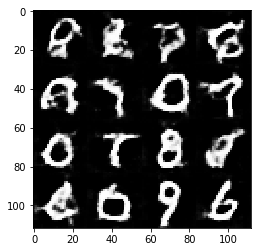

Epoch 2/2... d_loss: 0.9974... g_loss: 0.9394
Epoch 2/2... d_loss: 1.1711... g_loss: 1.7756
Epoch 2/2... d_loss: 1.0012... g_loss: 1.2282
Epoch 2/2... d_loss: 1.0015... g_loss: 0.8415
Epoch 2/2... d_loss: 1.0422... g_loss: 0.8134


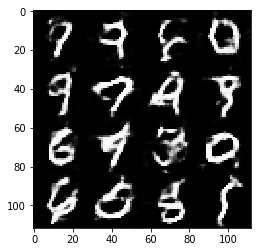

Epoch 2/2... d_loss: 0.9175... g_loss: 0.9198
Epoch 2/2... d_loss: 1.2955... g_loss: 0.4409
Epoch 2/2... d_loss: 1.0345... g_loss: 0.7116
Epoch 2/2... d_loss: 1.5874... g_loss: 0.2944
Epoch 2/2... d_loss: 1.0149... g_loss: 0.8233


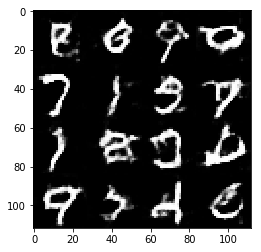

Epoch 2/2... d_loss: 1.0022... g_loss: 0.7322
Epoch 2/2... d_loss: 0.8581... g_loss: 0.9370
Epoch 2/2... d_loss: 0.9460... g_loss: 1.7148
Epoch 2/2... d_loss: 1.0181... g_loss: 1.1008
Epoch 2/2... d_loss: 1.0345... g_loss: 2.2269


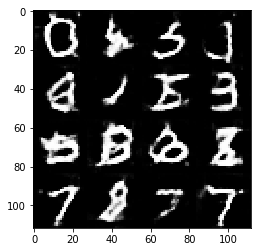

Epoch 2/2... d_loss: 0.8651... g_loss: 1.0272
Epoch 2/2... d_loss: 1.1176... g_loss: 1.3287
Epoch 2/2... d_loss: 1.2235... g_loss: 0.5979
Epoch 2/2... d_loss: 1.7620... g_loss: 0.2337
Epoch 2/2... d_loss: 1.2430... g_loss: 0.4767


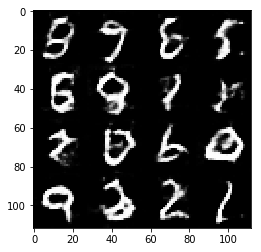

Epoch 2/2... d_loss: 1.0877... g_loss: 0.7555
Epoch 2/2... d_loss: 2.0714... g_loss: 3.1280
Epoch 2/2... d_loss: 1.1021... g_loss: 0.7604
Epoch 2/2... d_loss: 1.2780... g_loss: 0.4387
Epoch 2/2... d_loss: 0.9971... g_loss: 0.9726


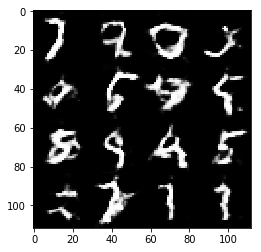

Epoch 2/2... d_loss: 0.9027... g_loss: 1.5615
Epoch 2/2... d_loss: 0.8781... g_loss: 1.0313
Epoch 2/2... d_loss: 0.8658... g_loss: 1.1132
Epoch 2/2... d_loss: 1.0442... g_loss: 0.5624
Epoch 2/2... d_loss: 1.2663... g_loss: 0.5528


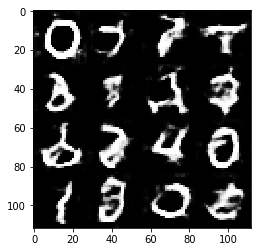

Epoch 2/2... d_loss: 1.2807... g_loss: 0.4978
Epoch 2/2... d_loss: 1.2800... g_loss: 1.7244
Epoch 2/2... d_loss: 1.1538... g_loss: 0.6593
Epoch 2/2... d_loss: 1.0903... g_loss: 1.0533
Epoch 2/2... d_loss: 0.9636... g_loss: 1.0856


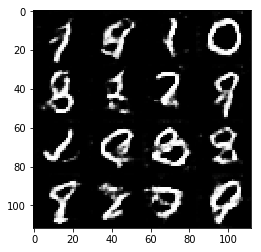

Epoch 2/2... d_loss: 0.8947... g_loss: 1.1453
Epoch 2/2... d_loss: 1.0707... g_loss: 0.6197
Epoch 2/2... d_loss: 1.1159... g_loss: 0.6400
Epoch 2/2... d_loss: 0.9165... g_loss: 1.1501
Epoch 2/2... d_loss: 1.2137... g_loss: 1.7890


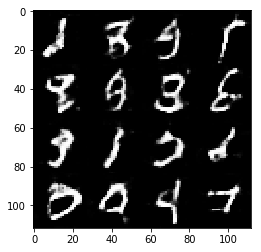

Epoch 2/2... d_loss: 1.2151... g_loss: 0.6690
Epoch 2/2... d_loss: 1.2600... g_loss: 0.5443
Epoch 2/2... d_loss: 1.0748... g_loss: 0.7942
Epoch 2/2... d_loss: 1.1555... g_loss: 1.2977
Epoch 2/2... d_loss: 0.9407... g_loss: 0.7837


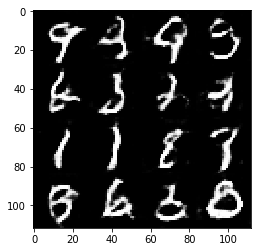

Epoch 2/2... d_loss: 1.0332... g_loss: 0.7658
Epoch 2/2... d_loss: 1.3296... g_loss: 1.5037
Epoch 2/2... d_loss: 0.8488... g_loss: 1.1521
Epoch 2/2... d_loss: 1.0606... g_loss: 0.7671
Epoch 2/2... d_loss: 0.9369... g_loss: 1.0535


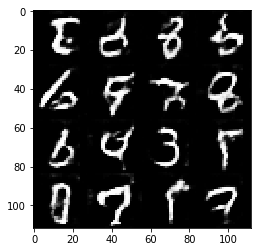

Epoch 2/2... d_loss: 1.0535... g_loss: 0.7060
Epoch 2/2... d_loss: 0.9557... g_loss: 0.7499
Epoch 2/2... d_loss: 0.8481... g_loss: 1.1974
Epoch 2/2... d_loss: 1.0397... g_loss: 0.7613
Epoch 2/2... d_loss: 1.0066... g_loss: 1.2807


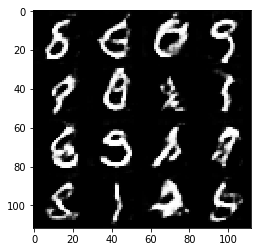

Epoch 2/2... d_loss: 1.1434... g_loss: 0.5558
Epoch 2/2... d_loss: 1.0029... g_loss: 0.6350
Epoch 2/2... d_loss: 0.8524... g_loss: 0.8503
Epoch 2/2... d_loss: 1.0948... g_loss: 0.5121
Epoch 2/2... d_loss: 0.9875... g_loss: 0.7091


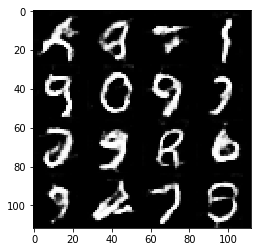

Epoch 2/2... d_loss: 0.9986... g_loss: 1.4325
Epoch 2/2... d_loss: 2.3288... g_loss: 2.6971
Epoch 2/2... d_loss: 0.9312... g_loss: 0.9257
Epoch 2/2... d_loss: 1.1187... g_loss: 0.6854
Epoch 2/2... d_loss: 0.9096... g_loss: 0.9408


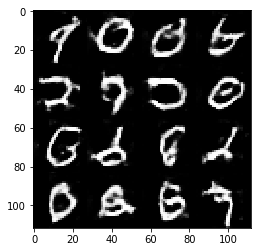

Epoch 2/2... d_loss: 1.0154... g_loss: 0.6923
Epoch 2/2... d_loss: 1.1235... g_loss: 1.6538
Epoch 2/2... d_loss: 1.2689... g_loss: 1.7251
Epoch 2/2... d_loss: 1.0547... g_loss: 1.7319
Epoch 2/2... d_loss: 0.8026... g_loss: 0.9194


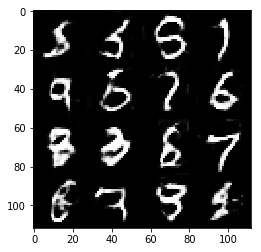

Epoch 2/2... d_loss: 1.4223... g_loss: 2.0588
Epoch 2/2... d_loss: 1.3213... g_loss: 0.4540
Epoch 2/2... d_loss: 0.8744... g_loss: 1.1050
Epoch 2/2... d_loss: 1.1108... g_loss: 1.7907
Epoch 2/2... d_loss: 1.0573... g_loss: 1.0546


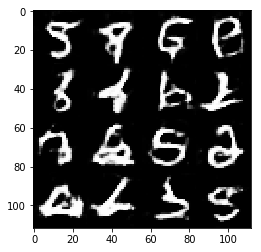

Epoch 2/2... d_loss: 0.8954... g_loss: 1.2560
Epoch 2/2... d_loss: 1.1560... g_loss: 0.5435
Epoch 2/2... d_loss: 1.0046... g_loss: 1.9501
Epoch 2/2... d_loss: 2.3918... g_loss: 3.1287
Epoch 2/2... d_loss: 1.0821... g_loss: 1.1812


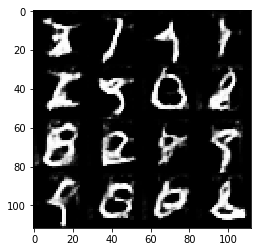

Epoch 2/2... d_loss: 1.1867... g_loss: 0.8372
Epoch 2/2... d_loss: 1.1435... g_loss: 0.6594
Epoch 2/2... d_loss: 1.1218... g_loss: 0.8544
Epoch 2/2... d_loss: 1.0504... g_loss: 0.7557
Epoch 2/2... d_loss: 1.0199... g_loss: 0.8587


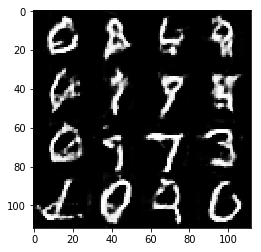

Epoch 2/2... d_loss: 1.1032... g_loss: 0.5610
Epoch 2/2... d_loss: 0.7992... g_loss: 1.6120


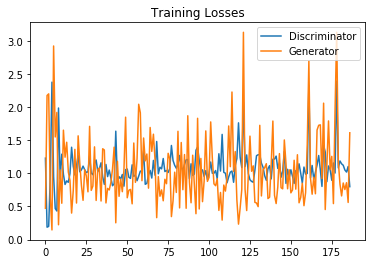

In [12]:
batch_size = 64
z_dim = 80
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... d_loss: 0.6440... g_loss: 1.6434
Epoch 1/1... d_loss: 0.4223... g_loss: 7.7731
Epoch 1/1... d_loss: 0.5020... g_loss: 15.4380
Epoch 1/1... d_loss: 0.1956... g_loss: 3.4734
Epoch 1/1... d_loss: 1.7468... g_loss: 17.6666


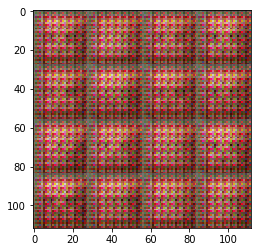

Epoch 1/1... d_loss: 3.9005... g_loss: 10.6627
Epoch 1/1... d_loss: 2.0613... g_loss: 0.7663
Epoch 1/1... d_loss: 1.4704... g_loss: 4.6129
Epoch 1/1... d_loss: 1.4288... g_loss: 0.4465
Epoch 1/1... d_loss: 0.9078... g_loss: 1.5308


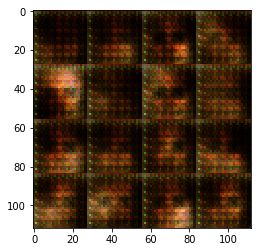

Epoch 1/1... d_loss: 1.2788... g_loss: 0.8068
Epoch 1/1... d_loss: 1.4180... g_loss: 0.4773
Epoch 1/1... d_loss: 0.6848... g_loss: 1.0092
Epoch 1/1... d_loss: 1.2650... g_loss: 0.5992
Epoch 1/1... d_loss: 3.1268... g_loss: 4.5337


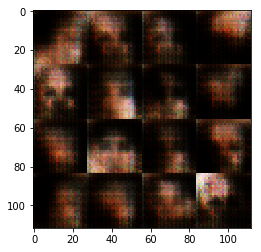

Epoch 1/1... d_loss: 0.6254... g_loss: 1.7429
Epoch 1/1... d_loss: 3.8095... g_loss: 0.0367
Epoch 1/1... d_loss: 2.3206... g_loss: 0.1752
Epoch 1/1... d_loss: 1.8493... g_loss: 0.2873
Epoch 1/1... d_loss: 1.5337... g_loss: 0.7454


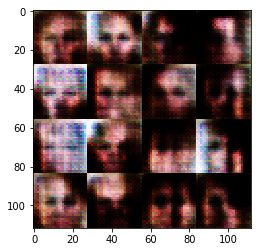

Epoch 1/1... d_loss: 2.1119... g_loss: 0.2129
Epoch 1/1... d_loss: 0.8156... g_loss: 0.7798
Epoch 1/1... d_loss: 2.0604... g_loss: 0.2237
Epoch 1/1... d_loss: 1.5968... g_loss: 0.2687
Epoch 1/1... d_loss: 0.5736... g_loss: 2.5864


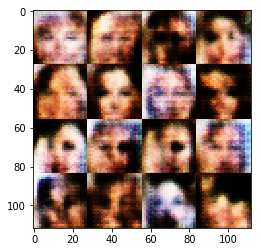

Epoch 1/1... d_loss: 0.4894... g_loss: 1.8850
Epoch 1/1... d_loss: 0.9842... g_loss: 1.9456
Epoch 1/1... d_loss: 1.7613... g_loss: 0.4149
Epoch 1/1... d_loss: 3.1705... g_loss: 0.0643
Epoch 1/1... d_loss: 1.8721... g_loss: 0.2316


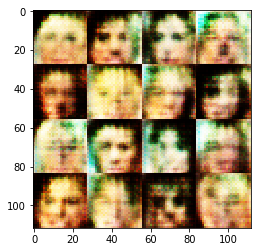

Epoch 1/1... d_loss: 3.4603... g_loss: 0.0497
Epoch 1/1... d_loss: 2.0657... g_loss: 0.2732
Epoch 1/1... d_loss: 1.3241... g_loss: 1.4211
Epoch 1/1... d_loss: 0.8580... g_loss: 0.8551
Epoch 1/1... d_loss: 1.8578... g_loss: 0.2419


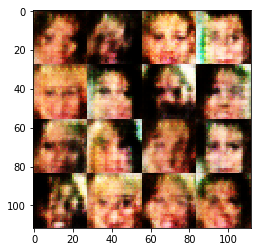

Epoch 1/1... d_loss: 2.3211... g_loss: 1.7191
Epoch 1/1... d_loss: 3.0084... g_loss: 0.0694
Epoch 1/1... d_loss: 2.5966... g_loss: 0.1229
Epoch 1/1... d_loss: 1.8016... g_loss: 0.9247
Epoch 1/1... d_loss: 0.9553... g_loss: 2.4795


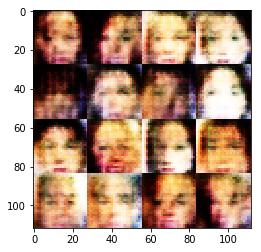

Epoch 1/1... d_loss: 1.3347... g_loss: 0.6816
Epoch 1/1... d_loss: 1.3058... g_loss: 1.7012
Epoch 1/1... d_loss: 0.5575... g_loss: 1.8315
Epoch 1/1... d_loss: 0.8975... g_loss: 0.7512
Epoch 1/1... d_loss: 2.1015... g_loss: 0.1719


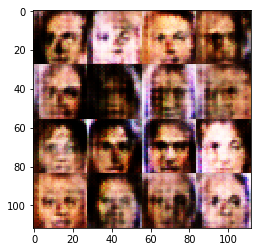

Epoch 1/1... d_loss: 2.0293... g_loss: 0.3096
Epoch 1/1... d_loss: 1.2227... g_loss: 0.6148
Epoch 1/1... d_loss: 1.5370... g_loss: 3.3882
Epoch 1/1... d_loss: 1.7216... g_loss: 0.2568
Epoch 1/1... d_loss: 2.0728... g_loss: 0.1940


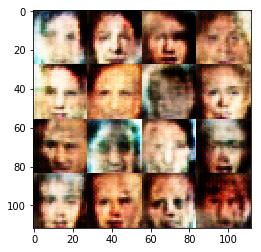

Epoch 1/1... d_loss: 1.8479... g_loss: 2.2288
Epoch 1/1... d_loss: 1.8464... g_loss: 1.9006
Epoch 1/1... d_loss: 1.3020... g_loss: 2.2124
Epoch 1/1... d_loss: 0.8885... g_loss: 2.1952
Epoch 1/1... d_loss: 0.2408... g_loss: 2.5945


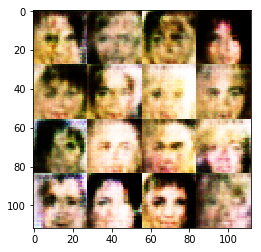

Epoch 1/1... d_loss: 2.1058... g_loss: 5.2139
Epoch 1/1... d_loss: 1.0491... g_loss: 0.6268
Epoch 1/1... d_loss: 2.1728... g_loss: 0.1885
Epoch 1/1... d_loss: 0.8186... g_loss: 1.0472
Epoch 1/1... d_loss: 0.5536... g_loss: 1.0331


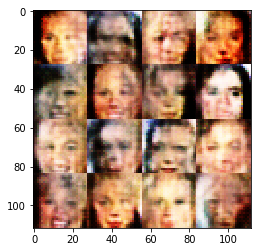

Epoch 1/1... d_loss: 3.6307... g_loss: 0.0425
Epoch 1/1... d_loss: 2.0560... g_loss: 1.9837
Epoch 1/1... d_loss: 1.8483... g_loss: 0.9848
Epoch 1/1... d_loss: 0.8386... g_loss: 1.6658
Epoch 1/1... d_loss: 0.3941... g_loss: 1.7181


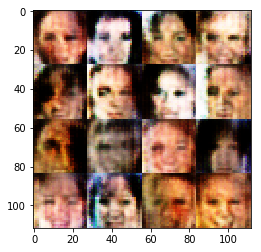

Epoch 1/1... d_loss: 0.3737... g_loss: 2.4385
Epoch 1/1... d_loss: 0.7262... g_loss: 0.9931
Epoch 1/1... d_loss: 0.3613... g_loss: 2.8369
Epoch 1/1... d_loss: 0.2617... g_loss: 2.3661
Epoch 1/1... d_loss: 0.1480... g_loss: 2.5351


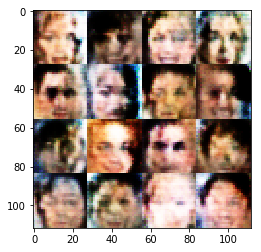

Epoch 1/1... d_loss: 0.1853... g_loss: 2.5388
Epoch 1/1... d_loss: 3.4313... g_loss: 4.2206
Epoch 1/1... d_loss: 2.1003... g_loss: 1.2363
Epoch 1/1... d_loss: 1.9161... g_loss: 0.7383
Epoch 1/1... d_loss: 1.7284... g_loss: 0.9673


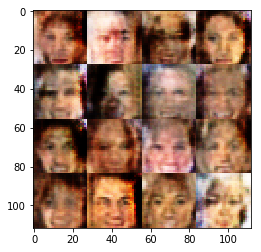

Epoch 1/1... d_loss: 1.6718... g_loss: 0.5613
Epoch 1/1... d_loss: 1.7404... g_loss: 0.5435
Epoch 1/1... d_loss: 2.1357... g_loss: 0.1996
Epoch 1/1... d_loss: 2.7371... g_loss: 0.0930
Epoch 1/1... d_loss: 1.1808... g_loss: 0.7747


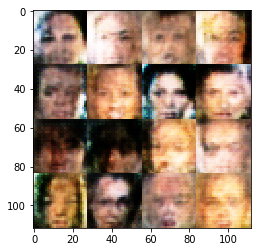

Epoch 1/1... d_loss: 1.0707... g_loss: 1.2771
Epoch 1/1... d_loss: 1.2535... g_loss: 0.9917
Epoch 1/1... d_loss: 2.4607... g_loss: 2.1762
Epoch 1/1... d_loss: 1.8402... g_loss: 1.0896
Epoch 1/1... d_loss: 2.7316... g_loss: 0.0943


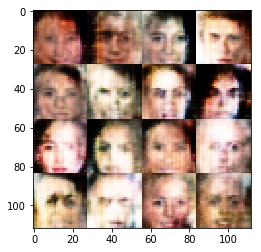

Epoch 1/1... d_loss: 2.0562... g_loss: 0.1826
Epoch 1/1... d_loss: 1.9743... g_loss: 0.2085
Epoch 1/1... d_loss: 2.2709... g_loss: 0.1623
Epoch 1/1... d_loss: 0.8100... g_loss: 1.8705
Epoch 1/1... d_loss: 2.3556... g_loss: 0.1226


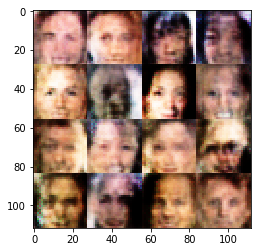

Epoch 1/1... d_loss: 0.8072... g_loss: 1.5783
Epoch 1/1... d_loss: 1.3969... g_loss: 1.4423
Epoch 1/1... d_loss: 0.5523... g_loss: 2.3444
Epoch 1/1... d_loss: 0.3424... g_loss: 2.1628
Epoch 1/1... d_loss: 1.0198... g_loss: 0.6825


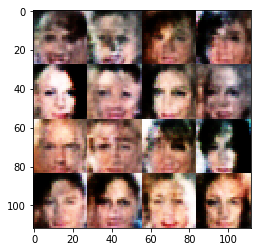

Epoch 1/1... d_loss: 1.5919... g_loss: 0.2842
Epoch 1/1... d_loss: 2.0297... g_loss: 0.2229
Epoch 1/1... d_loss: 1.4620... g_loss: 0.4150
Epoch 1/1... d_loss: 2.0925... g_loss: 0.1909
Epoch 1/1... d_loss: 1.6443... g_loss: 0.4085


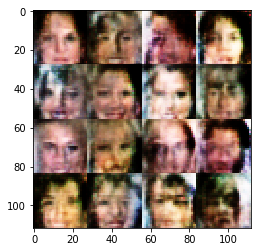

Epoch 1/1... d_loss: 1.9076... g_loss: 0.2366
Epoch 1/1... d_loss: 1.9097... g_loss: 0.2196
Epoch 1/1... d_loss: 1.9525... g_loss: 2.4555
Epoch 1/1... d_loss: 0.9313... g_loss: 0.6766
Epoch 1/1... d_loss: 0.6648... g_loss: 1.0187


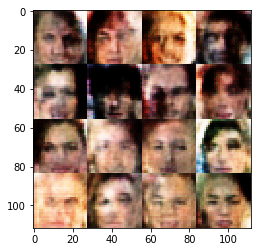

Epoch 1/1... d_loss: 2.2495... g_loss: 2.6414
Epoch 1/1... d_loss: 1.7033... g_loss: 0.2970
Epoch 1/1... d_loss: 0.6222... g_loss: 1.8941
Epoch 1/1... d_loss: 1.8699... g_loss: 1.7870
Epoch 1/1... d_loss: 1.0658... g_loss: 0.8588


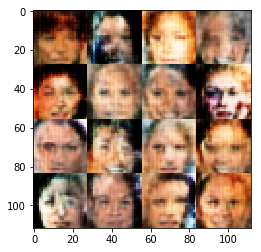

Epoch 1/1... d_loss: 0.6655... g_loss: 0.9175
Epoch 1/1... d_loss: 1.7323... g_loss: 0.2942
Epoch 1/1... d_loss: 2.6508... g_loss: 2.5142
Epoch 1/1... d_loss: 0.7211... g_loss: 0.9418
Epoch 1/1... d_loss: 0.4284... g_loss: 1.5522


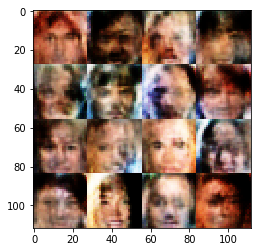

Epoch 1/1... d_loss: 1.5028... g_loss: 0.7778
Epoch 1/1... d_loss: 0.9058... g_loss: 1.6518
Epoch 1/1... d_loss: 1.1729... g_loss: 0.5674
Epoch 1/1... d_loss: 1.2978... g_loss: 1.4510
Epoch 1/1... d_loss: 1.8487... g_loss: 0.2152


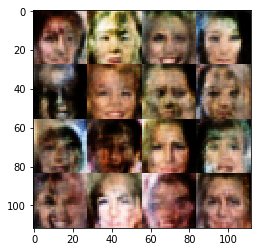

Epoch 1/1... d_loss: 0.4361... g_loss: 1.6724
Epoch 1/1... d_loss: 2.2027... g_loss: 3.1123
Epoch 1/1... d_loss: 1.2846... g_loss: 0.4453
Epoch 1/1... d_loss: 1.8124... g_loss: 0.2247
Epoch 1/1... d_loss: 1.2171... g_loss: 0.6870


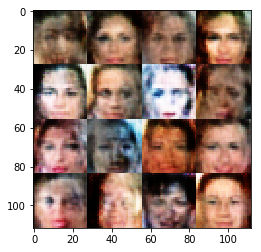

Epoch 1/1... d_loss: 0.6499... g_loss: 1.7186
Epoch 1/1... d_loss: 0.3108... g_loss: 1.9619
Epoch 1/1... d_loss: 0.3306... g_loss: 1.7354
Epoch 1/1... d_loss: 0.7211... g_loss: 0.9007
Epoch 1/1... d_loss: 0.9081... g_loss: 1.4549


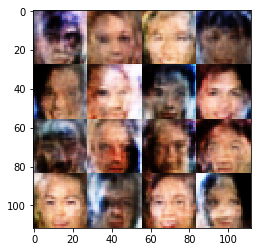

Epoch 1/1... d_loss: 1.0092... g_loss: 2.7343
Epoch 1/1... d_loss: 0.9606... g_loss: 1.7003
Epoch 1/1... d_loss: 2.2236... g_loss: 0.1477
Epoch 1/1... d_loss: 0.3213... g_loss: 2.1097
Epoch 1/1... d_loss: 0.4534... g_loss: 2.1915


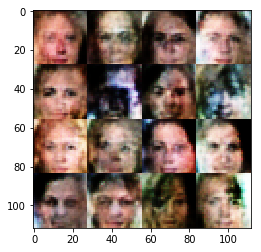

Epoch 1/1... d_loss: 2.9016... g_loss: 0.0756
Epoch 1/1... d_loss: 1.3243... g_loss: 1.0210
Epoch 1/1... d_loss: 1.9718... g_loss: 0.2009
Epoch 1/1... d_loss: 1.8811... g_loss: 0.2126
Epoch 1/1... d_loss: 0.3761... g_loss: 1.7652


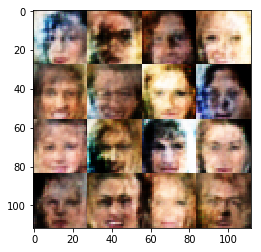

Epoch 1/1... d_loss: 0.9993... g_loss: 0.5636
Epoch 1/1... d_loss: 1.2546... g_loss: 0.4570
Epoch 1/1... d_loss: 1.0903... g_loss: 1.7011
Epoch 1/1... d_loss: 0.8683... g_loss: 0.8288
Epoch 1/1... d_loss: 0.2904... g_loss: 1.9553


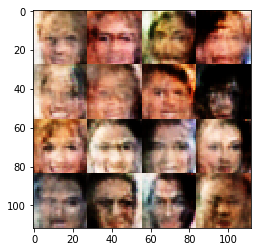

Epoch 1/1... d_loss: 0.9683... g_loss: 0.6150
Epoch 1/1... d_loss: 1.0874... g_loss: 1.1293
Epoch 1/1... d_loss: 1.8693... g_loss: 0.2240
Epoch 1/1... d_loss: 1.7588... g_loss: 0.2674
Epoch 1/1... d_loss: 1.9103... g_loss: 0.2467


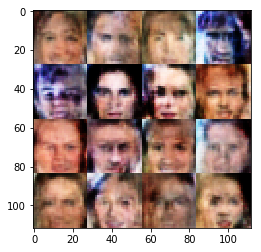

Epoch 1/1... d_loss: 1.4313... g_loss: 1.5073
Epoch 1/1... d_loss: 0.5839... g_loss: 1.1916
Epoch 1/1... d_loss: 1.8518... g_loss: 0.2476
Epoch 1/1... d_loss: 0.5814... g_loss: 1.4648
Epoch 1/1... d_loss: 0.5836... g_loss: 3.2991


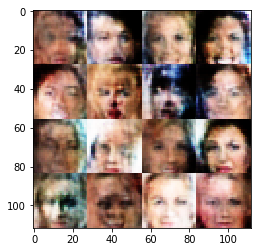

Epoch 1/1... d_loss: 1.6092... g_loss: 0.3213
Epoch 1/1... d_loss: 1.1951... g_loss: 1.5788
Epoch 1/1... d_loss: 1.1843... g_loss: 0.5174
Epoch 1/1... d_loss: 1.3477... g_loss: 0.8043
Epoch 1/1... d_loss: 1.3084... g_loss: 0.8225


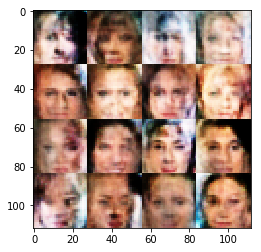

Epoch 1/1... d_loss: 0.6182... g_loss: 2.2696
Epoch 1/1... d_loss: 0.4632... g_loss: 1.5987
Epoch 1/1... d_loss: 1.6427... g_loss: 0.6514
Epoch 1/1... d_loss: 1.1592... g_loss: 1.3918
Epoch 1/1... d_loss: 1.8944... g_loss: 0.2028


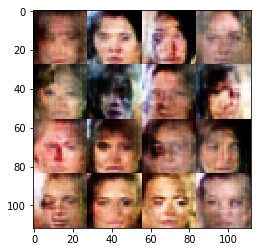

Epoch 1/1... d_loss: 1.1682... g_loss: 0.8361
Epoch 1/1... d_loss: 1.2437... g_loss: 0.5816
Epoch 1/1... d_loss: 0.4398... g_loss: 2.0064
Epoch 1/1... d_loss: 0.5862... g_loss: 1.9719
Epoch 1/1... d_loss: 0.8680... g_loss: 0.9403


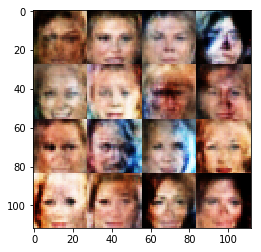

Epoch 1/1... d_loss: 0.7326... g_loss: 1.5640
Epoch 1/1... d_loss: 2.7858... g_loss: 0.0699
Epoch 1/1... d_loss: 0.6131... g_loss: 2.9989
Epoch 1/1... d_loss: 1.1443... g_loss: 1.5475
Epoch 1/1... d_loss: 1.4525... g_loss: 2.2933


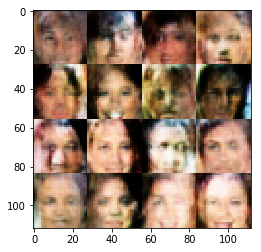

Epoch 1/1... d_loss: 1.0153... g_loss: 0.6291
Epoch 1/1... d_loss: 2.0601... g_loss: 2.2899
Epoch 1/1... d_loss: 1.1918... g_loss: 0.6042
Epoch 1/1... d_loss: 2.1913... g_loss: 0.1459
Epoch 1/1... d_loss: 1.9877... g_loss: 0.2200


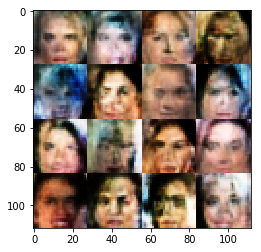

Epoch 1/1... d_loss: 0.5205... g_loss: 2.0225
Epoch 1/1... d_loss: 0.6205... g_loss: 1.0794
Epoch 1/1... d_loss: 1.2771... g_loss: 0.4483
Epoch 1/1... d_loss: 0.9855... g_loss: 1.7108
Epoch 1/1... d_loss: 1.0261... g_loss: 2.1022


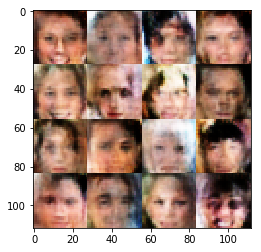

Epoch 1/1... d_loss: 0.7621... g_loss: 1.1644
Epoch 1/1... d_loss: 1.0004... g_loss: 0.9989
Epoch 1/1... d_loss: 0.2551... g_loss: 2.2113
Epoch 1/1... d_loss: 0.2806... g_loss: 2.7142
Epoch 1/1... d_loss: 0.6937... g_loss: 1.1481


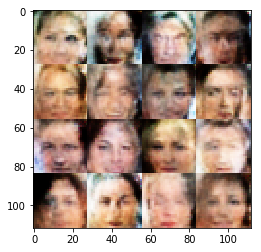

Epoch 1/1... d_loss: 1.1538... g_loss: 1.2972
Epoch 1/1... d_loss: 1.0886... g_loss: 0.8413
Epoch 1/1... d_loss: 1.6219... g_loss: 0.3062
Epoch 1/1... d_loss: 0.7114... g_loss: 1.2044
Epoch 1/1... d_loss: 0.4601... g_loss: 2.3321


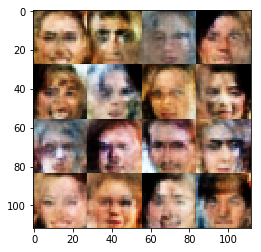

Epoch 1/1... d_loss: 0.9759... g_loss: 1.1665
Epoch 1/1... d_loss: 0.2060... g_loss: 2.8274
Epoch 1/1... d_loss: 1.0157... g_loss: 0.9313
Epoch 1/1... d_loss: 1.7124... g_loss: 0.3411
Epoch 1/1... d_loss: 0.7977... g_loss: 0.9096


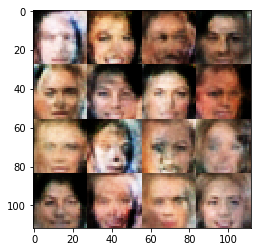

Epoch 1/1... d_loss: 0.4011... g_loss: 1.8430
Epoch 1/1... d_loss: 1.0930... g_loss: 1.0822
Epoch 1/1... d_loss: 2.4083... g_loss: 0.1316
Epoch 1/1... d_loss: 1.2008... g_loss: 0.6135
Epoch 1/1... d_loss: 0.7214... g_loss: 1.0214


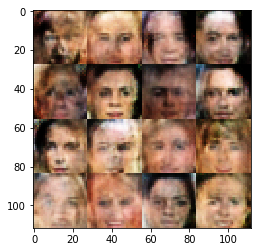

Epoch 1/1... d_loss: 2.7680... g_loss: 0.0969
Epoch 1/1... d_loss: 2.0133... g_loss: 0.1888
Epoch 1/1... d_loss: 1.6879... g_loss: 0.2969
Epoch 1/1... d_loss: 1.3879... g_loss: 0.7333
Epoch 1/1... d_loss: 0.5181... g_loss: 2.1034


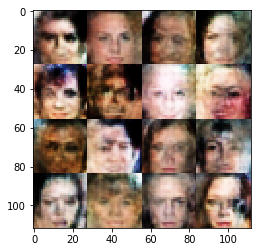

Epoch 1/1... d_loss: 0.4564... g_loss: 3.0530
Epoch 1/1... d_loss: 0.7029... g_loss: 1.3150
Epoch 1/1... d_loss: 1.6035... g_loss: 2.0031
Epoch 1/1... d_loss: 0.5537... g_loss: 1.1662
Epoch 1/1... d_loss: 2.2483... g_loss: 0.2136


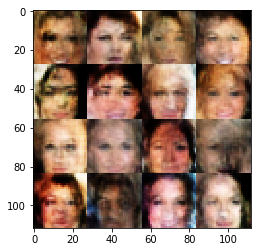

Epoch 1/1... d_loss: 1.4839... g_loss: 0.5952
Epoch 1/1... d_loss: 1.5902... g_loss: 1.2996
Epoch 1/1... d_loss: 2.3322... g_loss: 0.1608
Epoch 1/1... d_loss: 1.0045... g_loss: 1.7129
Epoch 1/1... d_loss: 1.2679... g_loss: 0.5265


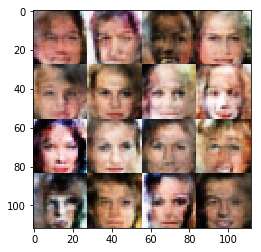

Epoch 1/1... d_loss: 0.7600... g_loss: 2.3063
Epoch 1/1... d_loss: 2.0956... g_loss: 0.1670
Epoch 1/1... d_loss: 1.1014... g_loss: 0.6515
Epoch 1/1... d_loss: 0.6864... g_loss: 1.2239
Epoch 1/1... d_loss: 0.8280... g_loss: 3.0965


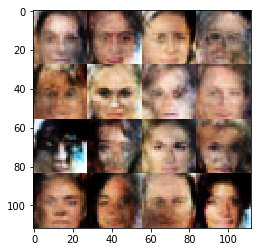

Epoch 1/1... d_loss: 1.0726... g_loss: 1.1130
Epoch 1/1... d_loss: 1.4006... g_loss: 0.4268
Epoch 1/1... d_loss: 0.6240... g_loss: 1.0492
Epoch 1/1... d_loss: 0.7920... g_loss: 0.8122
Epoch 1/1... d_loss: 1.6107... g_loss: 1.8766


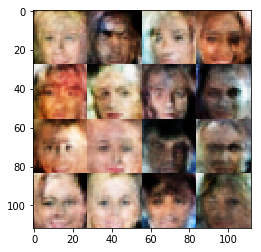

Epoch 1/1... d_loss: 1.0494... g_loss: 0.7778
Epoch 1/1... d_loss: 0.8415... g_loss: 2.7792
Epoch 1/1... d_loss: 0.3522... g_loss: 2.6086
Epoch 1/1... d_loss: 1.6615... g_loss: 0.3471
Epoch 1/1... d_loss: 1.3823... g_loss: 0.4588


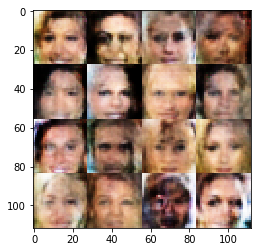

Epoch 1/1... d_loss: 0.3756... g_loss: 1.7377
Epoch 1/1... d_loss: 2.6001... g_loss: 3.6974
Epoch 1/1... d_loss: 1.2618... g_loss: 0.4341
Epoch 1/1... d_loss: 2.2874... g_loss: 0.1386
Epoch 1/1... d_loss: 1.9890... g_loss: 0.3037


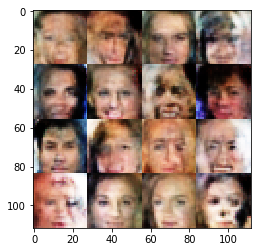

Epoch 1/1... d_loss: 0.7787... g_loss: 2.3392
Epoch 1/1... d_loss: 0.7385... g_loss: 2.7255
Epoch 1/1... d_loss: 0.6086... g_loss: 1.7192
Epoch 1/1... d_loss: 1.2647... g_loss: 2.3793
Epoch 1/1... d_loss: 0.8701... g_loss: 1.0691


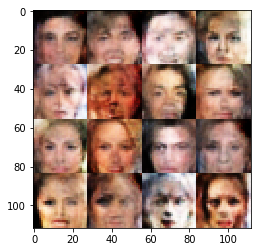

Epoch 1/1... d_loss: 0.8052... g_loss: 1.7355
Epoch 1/1... d_loss: 0.4824... g_loss: 1.2850
Epoch 1/1... d_loss: 1.0129... g_loss: 0.6751
Epoch 1/1... d_loss: 1.6384... g_loss: 0.3220
Epoch 1/1... d_loss: 1.1963... g_loss: 1.0849


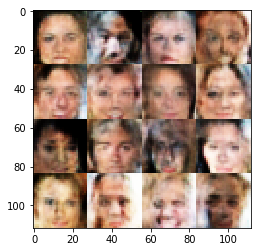

Epoch 1/1... d_loss: 1.1316... g_loss: 0.5660
Epoch 1/1... d_loss: 0.6908... g_loss: 2.5577
Epoch 1/1... d_loss: 0.4867... g_loss: 1.3731
Epoch 1/1... d_loss: 0.8898... g_loss: 0.9114
Epoch 1/1... d_loss: 2.3945... g_loss: 3.2347


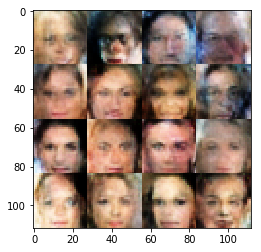

Epoch 1/1... d_loss: 0.7987... g_loss: 3.2497
Epoch 1/1... d_loss: 1.1946... g_loss: 0.5667
Epoch 1/1... d_loss: 0.8002... g_loss: 1.0895
Epoch 1/1... d_loss: 1.0860... g_loss: 1.0902
Epoch 1/1... d_loss: 0.7452... g_loss: 0.9860


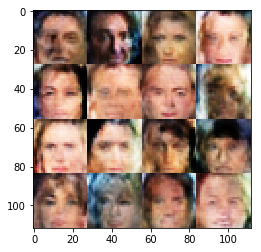

Epoch 1/1... d_loss: 1.5632... g_loss: 0.3353
Epoch 1/1... d_loss: 0.4153... g_loss: 2.7296
Epoch 1/1... d_loss: 1.3158... g_loss: 0.4653
Epoch 1/1... d_loss: 1.4410... g_loss: 0.7240
Epoch 1/1... d_loss: 0.8975... g_loss: 1.9776


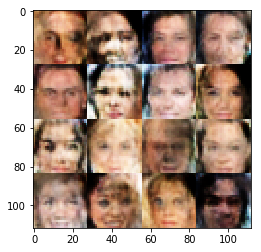

Epoch 1/1... d_loss: 1.2232... g_loss: 1.3969
Epoch 1/1... d_loss: 0.8971... g_loss: 1.6280
Epoch 1/1... d_loss: 0.6198... g_loss: 2.8585
Epoch 1/1... d_loss: 0.4839... g_loss: 1.3934
Epoch 1/1... d_loss: 0.7854... g_loss: 2.4869


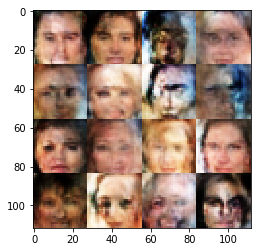

Epoch 1/1... d_loss: 1.4688... g_loss: 0.4226
Epoch 1/1... d_loss: 1.7628... g_loss: 0.2537
Epoch 1/1... d_loss: 0.5288... g_loss: 1.5385
Epoch 1/1... d_loss: 1.7237... g_loss: 3.5412
Epoch 1/1... d_loss: 0.5392... g_loss: 1.7789


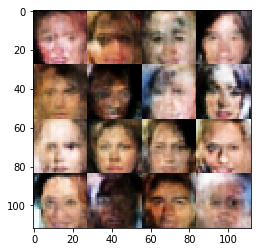

Epoch 1/1... d_loss: 2.1950... g_loss: 0.1398
Epoch 1/1... d_loss: 0.6317... g_loss: 1.4616
Epoch 1/1... d_loss: 0.3975... g_loss: 1.6166
Epoch 1/1... d_loss: 0.4844... g_loss: 1.8884
Epoch 1/1... d_loss: 0.6319... g_loss: 2.7330


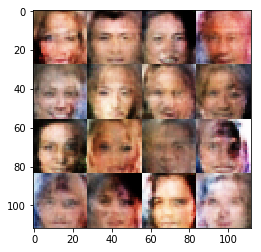

Epoch 1/1... d_loss: 0.7210... g_loss: 2.4737
Epoch 1/1... d_loss: 1.1684... g_loss: 0.5621
Epoch 1/1... d_loss: 0.9879... g_loss: 2.6859
Epoch 1/1... d_loss: 0.5020... g_loss: 1.4502
Epoch 1/1... d_loss: 0.8142... g_loss: 0.8639


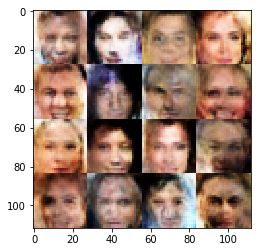

Epoch 1/1... d_loss: 1.1873... g_loss: 0.5122
Epoch 1/1... d_loss: 1.3602... g_loss: 0.6408
Epoch 1/1... d_loss: 0.7351... g_loss: 1.2501
Epoch 1/1... d_loss: 0.8917... g_loss: 0.8717
Epoch 1/1... d_loss: 0.5462... g_loss: 2.3692


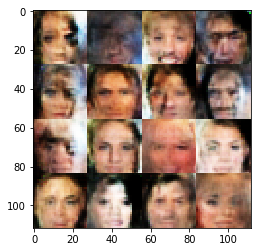

Epoch 1/1... d_loss: 1.8369... g_loss: 2.1953
Epoch 1/1... d_loss: 2.5745... g_loss: 0.1324
Epoch 1/1... d_loss: 1.1378... g_loss: 2.9619
Epoch 1/1... d_loss: 1.1363... g_loss: 0.5480
Epoch 1/1... d_loss: 0.5108... g_loss: 2.0823


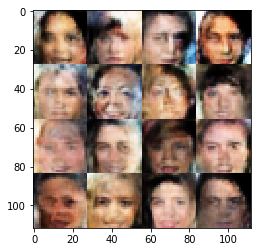

Epoch 1/1... d_loss: 0.1744... g_loss: 2.4875
Epoch 1/1... d_loss: 0.7306... g_loss: 2.1710
Epoch 1/1... d_loss: 0.9930... g_loss: 2.0972
Epoch 1/1... d_loss: 0.6879... g_loss: 0.8659
Epoch 1/1... d_loss: 0.5870... g_loss: 2.0680


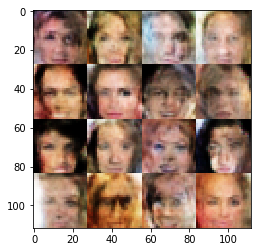

Epoch 1/1... d_loss: 2.0503... g_loss: 2.5590
Epoch 1/1... d_loss: 1.2901... g_loss: 0.9423
Epoch 1/1... d_loss: 1.3041... g_loss: 0.4812
Epoch 1/1... d_loss: 1.8662... g_loss: 0.2114
Epoch 1/1... d_loss: 0.8706... g_loss: 1.6872


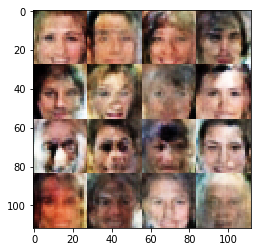

Epoch 1/1... d_loss: 1.1340... g_loss: 0.9024
Epoch 1/1... d_loss: 1.2196... g_loss: 0.6003
Epoch 1/1... d_loss: 1.8394... g_loss: 0.2659
Epoch 1/1... d_loss: 1.1533... g_loss: 0.5695
Epoch 1/1... d_loss: 1.2194... g_loss: 1.7322


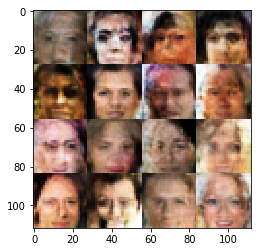

Epoch 1/1... d_loss: 0.4290... g_loss: 2.2348
Epoch 1/1... d_loss: 2.3835... g_loss: 2.0914
Epoch 1/1... d_loss: 0.6813... g_loss: 1.5537
Epoch 1/1... d_loss: 1.3146... g_loss: 0.4325
Epoch 1/1... d_loss: 0.6001... g_loss: 1.4866


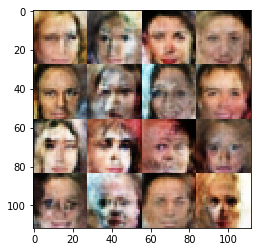

Epoch 1/1... d_loss: 0.6888... g_loss: 1.0115
Epoch 1/1... d_loss: 1.1112... g_loss: 1.1734
Epoch 1/1... d_loss: 0.8963... g_loss: 2.9491
Epoch 1/1... d_loss: 0.6513... g_loss: 1.1154
Epoch 1/1... d_loss: 1.1021... g_loss: 0.6288


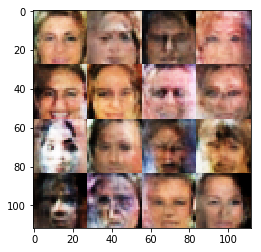

Epoch 1/1... d_loss: 1.6113... g_loss: 0.3099
Epoch 1/1... d_loss: 0.4748... g_loss: 1.4289
Epoch 1/1... d_loss: 0.5242... g_loss: 1.3342
Epoch 1/1... d_loss: 2.0108... g_loss: 1.2818
Epoch 1/1... d_loss: 0.7620... g_loss: 0.9421


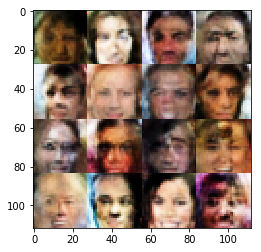

Epoch 1/1... d_loss: 0.9953... g_loss: 0.8746
Epoch 1/1... d_loss: 0.8424... g_loss: 2.9868
Epoch 1/1... d_loss: 0.6630... g_loss: 1.5241
Epoch 1/1... d_loss: 1.2091... g_loss: 0.5990
Epoch 1/1... d_loss: 1.4855... g_loss: 0.3620


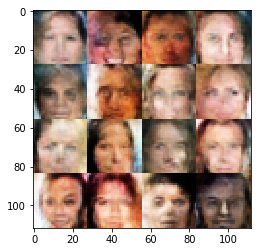

Epoch 1/1... d_loss: 0.2364... g_loss: 2.7738
Epoch 1/1... d_loss: 1.4529... g_loss: 0.3497
Epoch 1/1... d_loss: 0.6330... g_loss: 0.9220
Epoch 1/1... d_loss: 0.5921... g_loss: 1.1905
Epoch 1/1... d_loss: 0.9130... g_loss: 1.6656


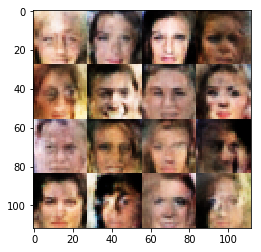

Epoch 1/1... d_loss: 2.8019... g_loss: 2.5667
Epoch 1/1... d_loss: 0.9404... g_loss: 0.6529
Epoch 1/1... d_loss: 0.2513... g_loss: 2.2824
Epoch 1/1... d_loss: 0.6461... g_loss: 1.7227
Epoch 1/1... d_loss: 0.3584... g_loss: 2.1686


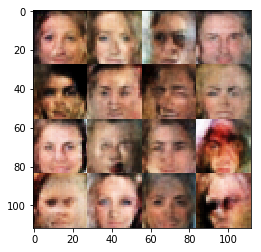

Epoch 1/1... d_loss: 2.4001... g_loss: 2.7468
Epoch 1/1... d_loss: 1.0629... g_loss: 1.9455
Epoch 1/1... d_loss: 1.1696... g_loss: 0.5353
Epoch 1/1... d_loss: 0.6823... g_loss: 1.5419
Epoch 1/1... d_loss: 1.0057... g_loss: 1.2642


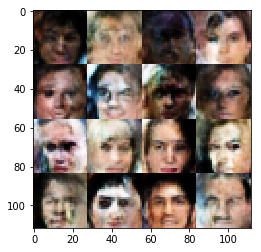

Epoch 1/1... d_loss: 1.2901... g_loss: 2.0401
Epoch 1/1... d_loss: 0.6768... g_loss: 1.6128
Epoch 1/1... d_loss: 0.8404... g_loss: 0.8639
Epoch 1/1... d_loss: 0.9003... g_loss: 0.7628
Epoch 1/1... d_loss: 1.5208... g_loss: 1.9524


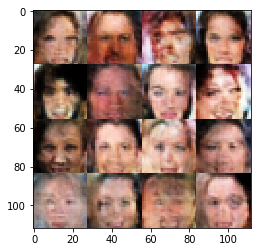

Epoch 1/1... d_loss: 0.4024... g_loss: 2.9621
Epoch 1/1... d_loss: 1.2720... g_loss: 0.6452
Epoch 1/1... d_loss: 0.4194... g_loss: 1.9313
Epoch 1/1... d_loss: 0.5986... g_loss: 2.1137
Epoch 1/1... d_loss: 0.2835... g_loss: 3.1192


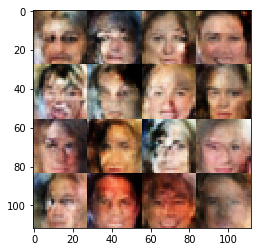

Epoch 1/1... d_loss: 0.7519... g_loss: 1.0179
Epoch 1/1... d_loss: 0.6485... g_loss: 2.9577
Epoch 1/1... d_loss: 0.3040... g_loss: 3.4037
Epoch 1/1... d_loss: 3.6136... g_loss: 3.6521
Epoch 1/1... d_loss: 1.1453... g_loss: 0.8201


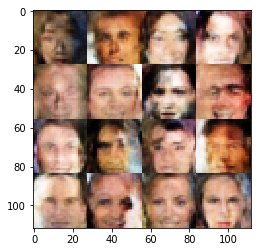

Epoch 1/1... d_loss: 0.8391... g_loss: 0.9815
Epoch 1/1... d_loss: 1.1763... g_loss: 0.5890
Epoch 1/1... d_loss: 0.5606... g_loss: 3.6401
Epoch 1/1... d_loss: 0.8196... g_loss: 1.8521
Epoch 1/1... d_loss: 1.6192... g_loss: 0.2831


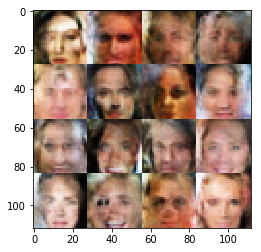

Epoch 1/1... d_loss: 1.1002... g_loss: 0.6801
Epoch 1/1... d_loss: 1.5505... g_loss: 0.4128
Epoch 1/1... d_loss: 1.0010... g_loss: 1.7886
Epoch 1/1... d_loss: 0.9982... g_loss: 0.7181
Epoch 1/1... d_loss: 0.3707... g_loss: 1.9959


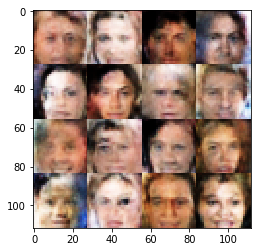

Epoch 1/1... d_loss: 0.5424... g_loss: 2.7539
Epoch 1/1... d_loss: 2.4784... g_loss: 0.1210
Epoch 1/1... d_loss: 1.3292... g_loss: 1.6338
Epoch 1/1... d_loss: 0.9472... g_loss: 1.8741
Epoch 1/1... d_loss: 1.1493... g_loss: 0.8638


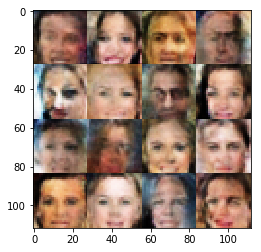

Epoch 1/1... d_loss: 0.6258... g_loss: 1.7201
Epoch 1/1... d_loss: 0.6739... g_loss: 1.1388
Epoch 1/1... d_loss: 1.2410... g_loss: 0.6798
Epoch 1/1... d_loss: 0.3923... g_loss: 1.6556
Epoch 1/1... d_loss: 0.6540... g_loss: 0.9877


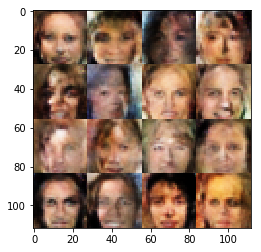

Epoch 1/1... d_loss: 0.9173... g_loss: 0.7111
Epoch 1/1... d_loss: 0.6608... g_loss: 1.4436
Epoch 1/1... d_loss: 0.2490... g_loss: 2.9455
Epoch 1/1... d_loss: 1.2059... g_loss: 0.4630
Epoch 1/1... d_loss: 1.1200... g_loss: 0.5297


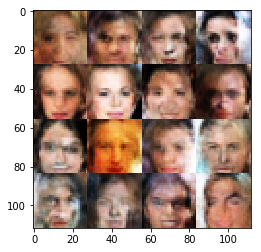

Epoch 1/1... d_loss: 0.4209... g_loss: 1.7557
Epoch 1/1... d_loss: 0.2129... g_loss: 3.8653
Epoch 1/1... d_loss: 1.3401... g_loss: 1.7799
Epoch 1/1... d_loss: 0.7931... g_loss: 0.8222
Epoch 1/1... d_loss: 0.3648... g_loss: 2.2629


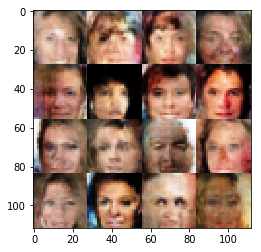

Epoch 1/1... d_loss: 0.3240... g_loss: 2.3724
Epoch 1/1... d_loss: 0.5876... g_loss: 4.3101
Epoch 1/1... d_loss: 0.3671... g_loss: 1.7561
Epoch 1/1... d_loss: 0.4143... g_loss: 3.2133
Epoch 1/1... d_loss: 0.3445... g_loss: 1.7661


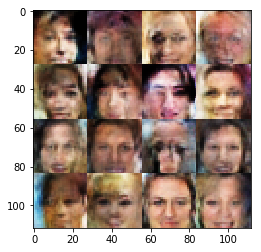

Epoch 1/1... d_loss: 3.3131... g_loss: 0.0561
Epoch 1/1... d_loss: 0.6917... g_loss: 2.4260
Epoch 1/1... d_loss: 0.6739... g_loss: 2.0287
Epoch 1/1... d_loss: 0.6471... g_loss: 2.5233
Epoch 1/1... d_loss: 0.7281... g_loss: 0.9495


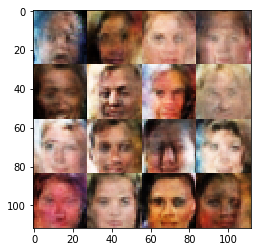

Epoch 1/1... d_loss: 0.7991... g_loss: 2.6164
Epoch 1/1... d_loss: 0.7360... g_loss: 1.0618
Epoch 1/1... d_loss: 0.7877... g_loss: 3.0010
Epoch 1/1... d_loss: 0.4447... g_loss: 3.1142
Epoch 1/1... d_loss: 0.4161... g_loss: 1.5182


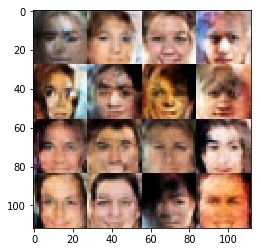

Epoch 1/1... d_loss: 0.5824... g_loss: 1.3068
Epoch 1/1... d_loss: 0.3928... g_loss: 1.5897
Epoch 1/1... d_loss: 1.0123... g_loss: 3.6639
Epoch 1/1... d_loss: 1.2535... g_loss: 2.1632
Epoch 1/1... d_loss: 2.1517... g_loss: 0.2042


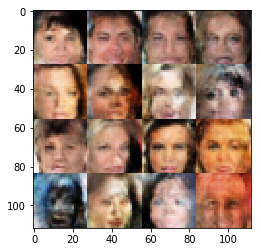

Epoch 1/1... d_loss: 2.8235... g_loss: 0.1004
Epoch 1/1... d_loss: 0.9256... g_loss: 1.6404
Epoch 1/1... d_loss: 0.3767... g_loss: 3.9026
Epoch 1/1... d_loss: 0.5793... g_loss: 1.2086
Epoch 1/1... d_loss: 0.6661... g_loss: 1.3496


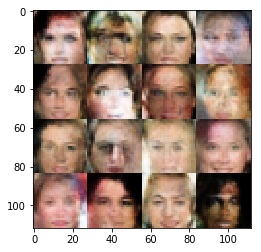

Epoch 1/1... d_loss: 2.6935... g_loss: 0.1054
Epoch 1/1... d_loss: 1.0634... g_loss: 0.5946
Epoch 1/1... d_loss: 0.6345... g_loss: 1.1576
Epoch 1/1... d_loss: 0.6414... g_loss: 2.4241
Epoch 1/1... d_loss: 0.3416... g_loss: 2.4528


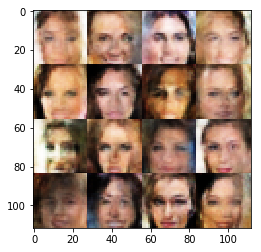

Epoch 1/1... d_loss: 1.6836... g_loss: 0.2759
Epoch 1/1... d_loss: 0.7983... g_loss: 0.9437
Epoch 1/1... d_loss: 1.2584... g_loss: 1.3303
Epoch 1/1... d_loss: 1.4168... g_loss: 0.4041
Epoch 1/1... d_loss: 0.8147... g_loss: 0.9397


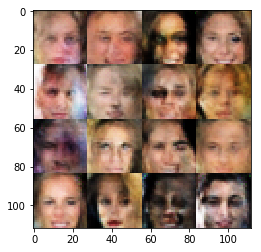

Epoch 1/1... d_loss: 0.4218... g_loss: 1.3589
Epoch 1/1... d_loss: 0.6001... g_loss: 1.6654
Epoch 1/1... d_loss: 0.8138... g_loss: 3.3506
Epoch 1/1... d_loss: 0.4357... g_loss: 2.0326
Epoch 1/1... d_loss: 1.7857... g_loss: 0.2523


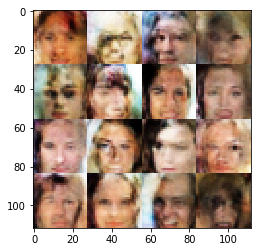

Epoch 1/1... d_loss: 1.0396... g_loss: 1.7632
Epoch 1/1... d_loss: 0.6218... g_loss: 2.3853
Epoch 1/1... d_loss: 1.0149... g_loss: 2.1547
Epoch 1/1... d_loss: 0.3895... g_loss: 2.2446
Epoch 1/1... d_loss: 0.5872... g_loss: 1.1853


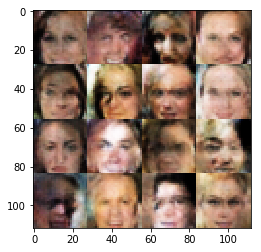

Epoch 1/1... d_loss: 1.6400... g_loss: 0.4179
Epoch 1/1... d_loss: 0.4808... g_loss: 2.2017
Epoch 1/1... d_loss: 2.1366... g_loss: 4.3069
Epoch 1/1... d_loss: 0.6686... g_loss: 2.0064
Epoch 1/1... d_loss: 0.3382... g_loss: 1.7820


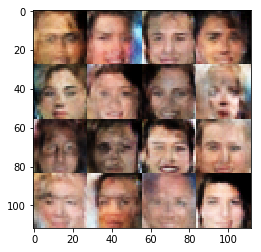

Epoch 1/1... d_loss: 0.5543... g_loss: 2.2734
Epoch 1/1... d_loss: 0.6386... g_loss: 1.1859
Epoch 1/1... d_loss: 0.3764... g_loss: 2.1231
Epoch 1/1... d_loss: 0.8537... g_loss: 1.7574
Epoch 1/1... d_loss: 0.4082... g_loss: 3.2118


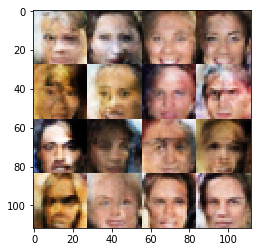

Epoch 1/1... d_loss: 3.1211... g_loss: 0.0617
Epoch 1/1... d_loss: 1.0718... g_loss: 1.1943
Epoch 1/1... d_loss: 1.5034... g_loss: 2.7460
Epoch 1/1... d_loss: 0.8166... g_loss: 1.3781
Epoch 1/1... d_loss: 0.5213... g_loss: 4.4261


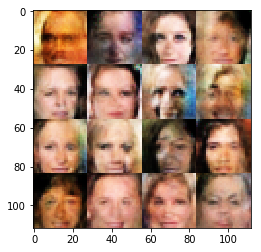

Epoch 1/1... d_loss: 0.5749... g_loss: 1.5622
Epoch 1/1... d_loss: 2.5163... g_loss: 2.3638
Epoch 1/1... d_loss: 0.7618... g_loss: 0.8673
Epoch 1/1... d_loss: 1.4600... g_loss: 0.3321
Epoch 1/1... d_loss: 0.6488... g_loss: 2.9884


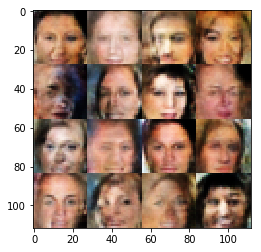

Epoch 1/1... d_loss: 0.3217... g_loss: 2.0787
Epoch 1/1... d_loss: 1.0083... g_loss: 0.9308
Epoch 1/1... d_loss: 0.4535... g_loss: 1.3584
Epoch 1/1... d_loss: 2.8572... g_loss: 0.0956
Epoch 1/1... d_loss: 1.4730... g_loss: 0.3685


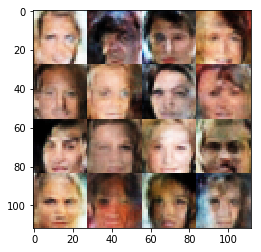

Epoch 1/1... d_loss: 1.2262... g_loss: 0.5681
Epoch 1/1... d_loss: 0.4441... g_loss: 3.0212
Epoch 1/1... d_loss: 1.1710... g_loss: 0.5950
Epoch 1/1... d_loss: 2.5001... g_loss: 2.3853
Epoch 1/1... d_loss: 0.8474... g_loss: 1.0163


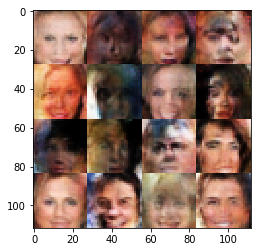

Epoch 1/1... d_loss: 0.9354... g_loss: 1.0557
Epoch 1/1... d_loss: 1.1357... g_loss: 0.5339
Epoch 1/1... d_loss: 1.4807... g_loss: 2.5635
Epoch 1/1... d_loss: 0.6618... g_loss: 1.0845
Epoch 1/1... d_loss: 0.9653... g_loss: 0.8312


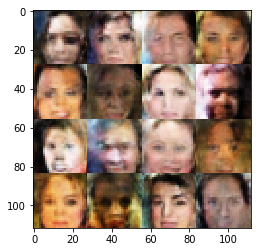

Epoch 1/1... d_loss: 0.5049... g_loss: 1.2033
Epoch 1/1... d_loss: 0.3681... g_loss: 2.5786
Epoch 1/1... d_loss: 0.4560... g_loss: 1.2060
Epoch 1/1... d_loss: 0.2486... g_loss: 2.2538
Epoch 1/1... d_loss: 0.2259... g_loss: 3.2469


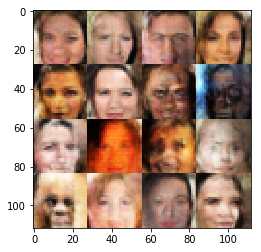

Epoch 1/1... d_loss: 2.4952... g_loss: 0.6002
Epoch 1/1... d_loss: 1.7364... g_loss: 0.3208
Epoch 1/1... d_loss: 0.8489... g_loss: 2.2984
Epoch 1/1... d_loss: 1.4724... g_loss: 0.3943
Epoch 1/1... d_loss: 1.1975... g_loss: 0.6040


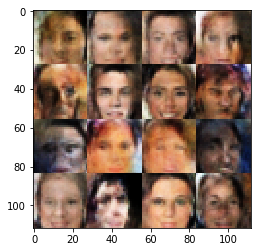

Epoch 1/1... d_loss: 0.6010... g_loss: 1.1354
Epoch 1/1... d_loss: 2.9553... g_loss: 2.4797
Epoch 1/1... d_loss: 0.8299... g_loss: 0.9350
Epoch 1/1... d_loss: 3.0349... g_loss: 0.0765
Epoch 1/1... d_loss: 0.6019... g_loss: 1.1812


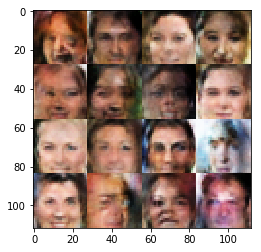

Epoch 1/1... d_loss: 0.3208... g_loss: 2.6507
Epoch 1/1... d_loss: 1.1555... g_loss: 0.4935
Epoch 1/1... d_loss: 0.4463... g_loss: 2.1049
Epoch 1/1... d_loss: 0.5978... g_loss: 2.2715
Epoch 1/1... d_loss: 0.3315... g_loss: 1.7376


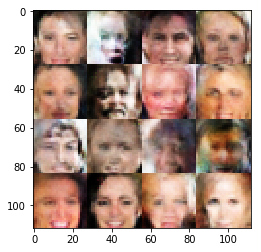

Epoch 1/1... d_loss: 0.8094... g_loss: 1.7590
Epoch 1/1... d_loss: 0.5084... g_loss: 1.3906
Epoch 1/1... d_loss: 1.8837... g_loss: 0.1904
Epoch 1/1... d_loss: 2.4013... g_loss: 0.1424
Epoch 1/1... d_loss: 0.9852... g_loss: 1.2694


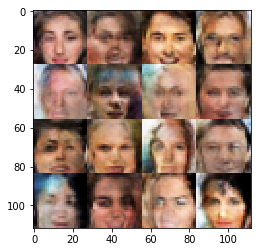

Epoch 1/1... d_loss: 0.7078... g_loss: 1.3486
Epoch 1/1... d_loss: 1.2466... g_loss: 0.5180
Epoch 1/1... d_loss: 0.8284... g_loss: 0.8171
Epoch 1/1... d_loss: 0.3571... g_loss: 2.7351
Epoch 1/1... d_loss: 1.1024... g_loss: 0.5237


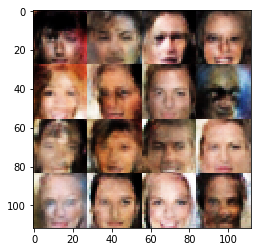

Epoch 1/1... d_loss: 0.3882... g_loss: 1.8110
Epoch 1/1... d_loss: 1.5862... g_loss: 2.7812
Epoch 1/1... d_loss: 1.0237... g_loss: 0.8258
Epoch 1/1... d_loss: 0.5248... g_loss: 1.0983
Epoch 1/1... d_loss: 0.4682... g_loss: 1.5263


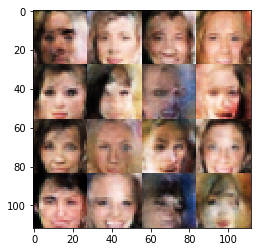

Epoch 1/1... d_loss: 1.4601... g_loss: 0.4075
Epoch 1/1... d_loss: 0.9378... g_loss: 0.7385
Epoch 1/1... d_loss: 0.2736... g_loss: 1.7842
Epoch 1/1... d_loss: 1.2074... g_loss: 0.5046
Epoch 1/1... d_loss: 0.6106... g_loss: 1.7399


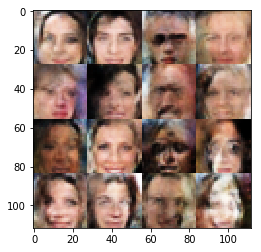

Epoch 1/1... d_loss: 0.6388... g_loss: 1.8524
Epoch 1/1... d_loss: 0.9571... g_loss: 0.7444
Epoch 1/1... d_loss: 0.9098... g_loss: 0.7962
Epoch 1/1... d_loss: 1.0959... g_loss: 0.6545
Epoch 1/1... d_loss: 2.4346... g_loss: 1.6047


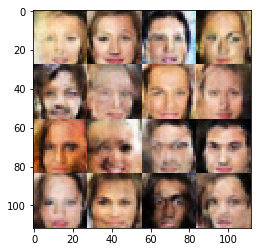

Epoch 1/1... d_loss: 1.1058... g_loss: 2.4139
Epoch 1/1... d_loss: 0.5990... g_loss: 2.8699
Epoch 1/1... d_loss: 0.4678... g_loss: 1.4600
Epoch 1/1... d_loss: 0.2597... g_loss: 2.2067
Epoch 1/1... d_loss: 0.3854... g_loss: 1.4761


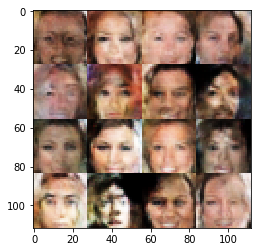

Epoch 1/1... d_loss: 0.1989... g_loss: 3.1720
Epoch 1/1... d_loss: 0.1506... g_loss: 3.3598
Epoch 1/1... d_loss: 0.3000... g_loss: 1.7986
Epoch 1/1... d_loss: 0.3735... g_loss: 1.5235
Epoch 1/1... d_loss: 0.5009... g_loss: 1.4010


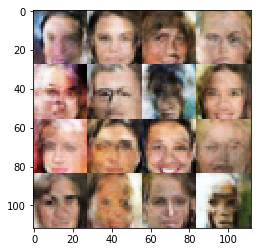

Epoch 1/1... d_loss: 0.3150... g_loss: 1.8696
Epoch 1/1... d_loss: 0.2768... g_loss: 4.2726
Epoch 1/1... d_loss: 1.3752... g_loss: 2.5358
Epoch 1/1... d_loss: 0.3747... g_loss: 1.7447
Epoch 1/1... d_loss: 1.5170... g_loss: 0.3852


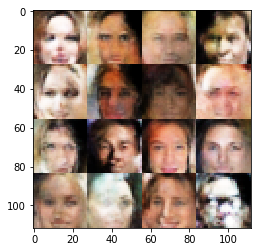

Epoch 1/1... d_loss: 1.3308... g_loss: 0.4432
Epoch 1/1... d_loss: 0.7351... g_loss: 1.1099
Epoch 1/1... d_loss: 0.2738... g_loss: 3.0660
Epoch 1/1... d_loss: 2.7503... g_loss: 0.0845
Epoch 1/1... d_loss: 1.2576... g_loss: 0.5545


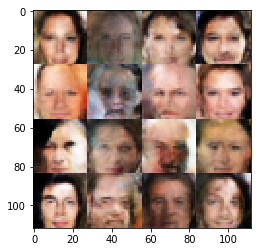

Epoch 1/1... d_loss: 1.0522... g_loss: 1.6193
Epoch 1/1... d_loss: 2.3169... g_loss: 0.1485
Epoch 1/1... d_loss: 2.1815... g_loss: 0.2144
Epoch 1/1... d_loss: 0.7373... g_loss: 1.0114
Epoch 1/1... d_loss: 1.1066... g_loss: 0.5749


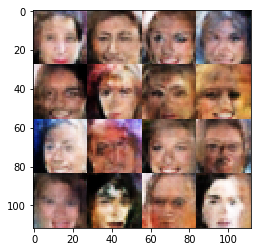

Epoch 1/1... d_loss: 1.0074... g_loss: 0.8910
Epoch 1/1... d_loss: 0.5789... g_loss: 1.2061
Epoch 1/1... d_loss: 0.4162... g_loss: 2.4992
Epoch 1/1... d_loss: 0.3341... g_loss: 1.9310
Epoch 1/1... d_loss: 0.8252... g_loss: 2.6915


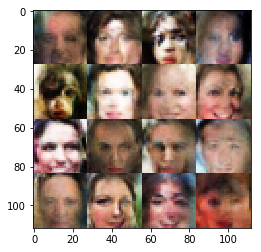

Epoch 1/1... d_loss: 0.7564... g_loss: 0.8713
Epoch 1/1... d_loss: 0.5717... g_loss: 2.1335
Epoch 1/1... d_loss: 0.5369... g_loss: 1.1008
Epoch 1/1... d_loss: 0.8866... g_loss: 2.4633
Epoch 1/1... d_loss: 0.8248... g_loss: 0.8654


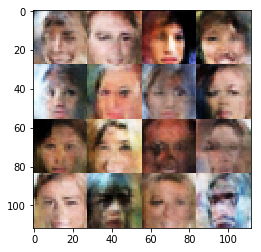

Epoch 1/1... d_loss: 0.4375... g_loss: 1.5477
Epoch 1/1... d_loss: 0.7694... g_loss: 0.8954
Epoch 1/1... d_loss: 1.1132... g_loss: 1.0384
Epoch 1/1... d_loss: 0.4468... g_loss: 2.3446
Epoch 1/1... d_loss: 0.6470... g_loss: 1.3032


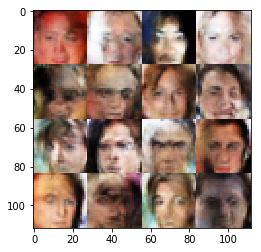

Epoch 1/1... d_loss: 0.1383... g_loss: 2.8031
Epoch 1/1... d_loss: 0.2353... g_loss: 2.5760
Epoch 1/1... d_loss: 1.1461... g_loss: 0.6264
Epoch 1/1... d_loss: 0.2155... g_loss: 2.4099
Epoch 1/1... d_loss: 0.1298... g_loss: 3.3852


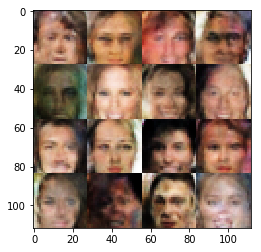

Epoch 1/1... d_loss: 0.9274... g_loss: 0.7924
Epoch 1/1... d_loss: 1.1245... g_loss: 0.5060
Epoch 1/1... d_loss: 0.4618... g_loss: 1.7907
Epoch 1/1... d_loss: 0.4126... g_loss: 1.6751
Epoch 1/1... d_loss: 0.2868... g_loss: 2.9397


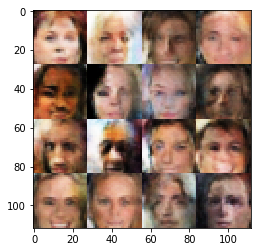

Epoch 1/1... d_loss: 0.4483... g_loss: 1.3308
Epoch 1/1... d_loss: 2.1015... g_loss: 0.1788
Epoch 1/1... d_loss: 0.9893... g_loss: 0.8033
Epoch 1/1... d_loss: 2.4583... g_loss: 0.1271
Epoch 1/1... d_loss: 0.6554... g_loss: 1.8707


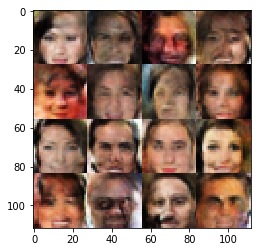

Epoch 1/1... d_loss: 1.2275... g_loss: 0.9453
Epoch 1/1... d_loss: 1.0153... g_loss: 0.6969
Epoch 1/1... d_loss: 2.1669... g_loss: 0.1926
Epoch 1/1... d_loss: 0.9773... g_loss: 0.7283
Epoch 1/1... d_loss: 0.3657... g_loss: 1.6488


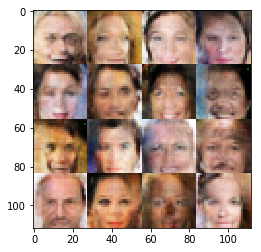

Epoch 1/1... d_loss: 0.6219... g_loss: 1.2974
Epoch 1/1... d_loss: 3.5757... g_loss: 3.7671
Epoch 1/1... d_loss: 1.2974... g_loss: 0.4157
Epoch 1/1... d_loss: 1.2063... g_loss: 0.5936
Epoch 1/1... d_loss: 0.3544... g_loss: 2.8842


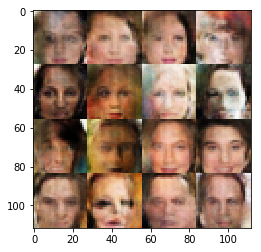

Epoch 1/1... d_loss: 0.7374... g_loss: 1.8490
Epoch 1/1... d_loss: 0.5727... g_loss: 5.1497
Epoch 1/1... d_loss: 0.1733... g_loss: 4.2401
Epoch 1/1... d_loss: 1.5221... g_loss: 2.7733
Epoch 1/1... d_loss: 0.5997... g_loss: 1.2747


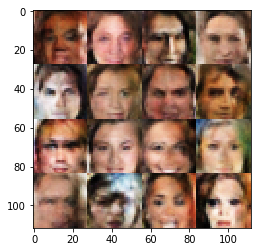

Epoch 1/1... d_loss: 0.5410... g_loss: 1.2648
Epoch 1/1... d_loss: 0.2856... g_loss: 2.0199
Epoch 1/1... d_loss: 0.5032... g_loss: 2.1874
Epoch 1/1... d_loss: 2.9371... g_loss: 2.7691
Epoch 1/1... d_loss: 1.5095... g_loss: 0.3850


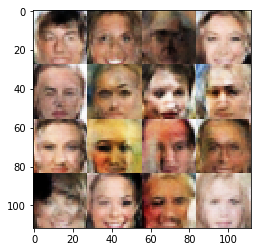

Epoch 1/1... d_loss: 0.8094... g_loss: 0.9068
Epoch 1/1... d_loss: 0.6406... g_loss: 2.5871
Epoch 1/1... d_loss: 0.8799... g_loss: 1.1798
Epoch 1/1... d_loss: 1.1931... g_loss: 0.5489
Epoch 1/1... d_loss: 0.6051... g_loss: 1.0229


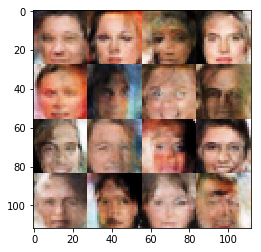

Epoch 1/1... d_loss: 1.9390... g_loss: 0.2333
Epoch 1/1... d_loss: 0.6069... g_loss: 1.6808
Epoch 1/1... d_loss: 0.2891... g_loss: 2.1832
Epoch 1/1... d_loss: 0.8227... g_loss: 0.8724
Epoch 1/1... d_loss: 0.4734... g_loss: 1.5202


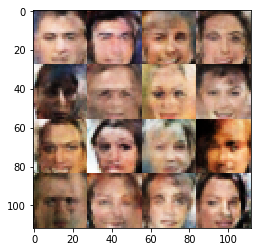

Epoch 1/1... d_loss: 2.2654... g_loss: 1.9078
Epoch 1/1... d_loss: 0.4993... g_loss: 1.3414
Epoch 1/1... d_loss: 1.0191... g_loss: 2.4703
Epoch 1/1... d_loss: 0.8006... g_loss: 1.0067
Epoch 1/1... d_loss: 0.9254... g_loss: 0.9503


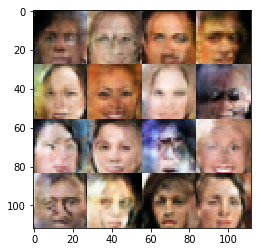

Epoch 1/1... d_loss: 0.8657... g_loss: 0.7527
Epoch 1/1... d_loss: 0.8417... g_loss: 0.8938
Epoch 1/1... d_loss: 1.0240... g_loss: 2.1758
Epoch 1/1... d_loss: 1.5987... g_loss: 0.3981
Epoch 1/1... d_loss: 0.7628... g_loss: 2.7682


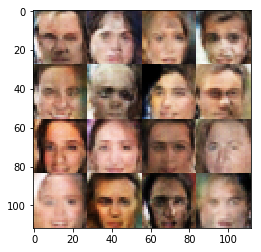

Epoch 1/1... d_loss: 0.6872... g_loss: 1.2478
Epoch 1/1... d_loss: 0.4396... g_loss: 2.0175
Epoch 1/1... d_loss: 0.6544... g_loss: 1.4423
Epoch 1/1... d_loss: 0.8797... g_loss: 0.9300
Epoch 1/1... d_loss: 0.7978... g_loss: 1.0537


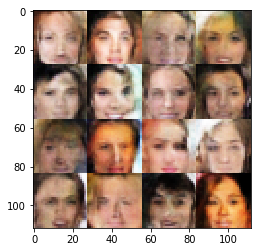

Epoch 1/1... d_loss: 0.3375... g_loss: 2.0320
Epoch 1/1... d_loss: 2.1157... g_loss: 3.6588
Epoch 1/1... d_loss: 0.5416... g_loss: 1.8373
Epoch 1/1... d_loss: 0.5113... g_loss: 3.1402
Epoch 1/1... d_loss: 1.3894... g_loss: 0.3673


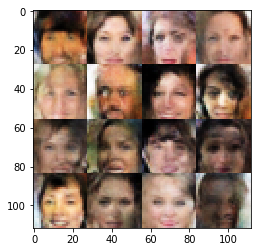

Epoch 1/1... d_loss: 0.9937... g_loss: 0.6855
Epoch 1/1... d_loss: 0.4523... g_loss: 1.5007
Epoch 1/1... d_loss: 0.7525... g_loss: 0.9234
Epoch 1/1... d_loss: 0.5132... g_loss: 1.9085
Epoch 1/1... d_loss: 1.7335... g_loss: 0.3785


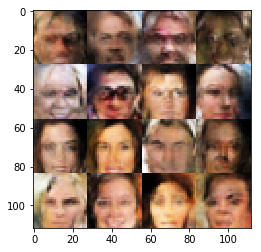

Epoch 1/1... d_loss: 1.3798... g_loss: 0.5173
Epoch 1/1... d_loss: 0.2453... g_loss: 3.0061
Epoch 1/1... d_loss: 0.5542... g_loss: 1.1996
Epoch 1/1... d_loss: 1.1536... g_loss: 1.9653
Epoch 1/1... d_loss: 0.7602... g_loss: 1.5338


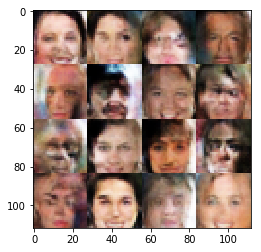

Epoch 1/1... d_loss: 1.9277... g_loss: 2.2873
Epoch 1/1... d_loss: 0.5645... g_loss: 1.7016
Epoch 1/1... d_loss: 3.4160... g_loss: 0.0897


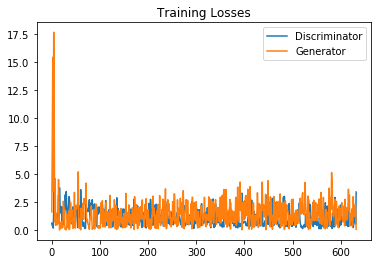

In [15]:
batch_size = 32
z_dim = 512
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.